# **Analyzing Citi Bike patterns in New York**

*A project for course 42577 Introduction to Business Analytics, by:*

* August B. Tollerup (s204139)
* Phillip C. Højbjerg (s184984)
* Jonas R. Gjerris (s184202)
* Line S. M. Petersen (s193973)

*Word count: 2039*

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import osmnx as ox
from haversine import haversine, Unit
import shapely.geometry

import holidays

# Dissable warnings
import warnings
warnings.filterwarnings('ignore')

# Setting seeds
np.random.seed(42)

# 1 Introduction

*WRITE ABOUT OVERALL PROJECT BACKGROUND, DESCRIPTION AND MOTIVATION*

# 2 Data Analysis and Visualization

*WRITE INTRODUCTION TO SECTION 2 AND APPROACH*

*WRITE SOMETHING ABOUT DATA LOADING + PRE-PROCESSING (e.g. dropping unnamed column)*

In [2]:
# Fetching data
data = pd.read_csv('Trips_2018.csv')

# Dropping unnamed column
data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [3]:
print(f"Size of the dataset: {data.shape}")
print("Data snippet:")
data.head()

Size of the dataset: (17548339, 13)
Data snippet:


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


Above, we can see that the dataset has a total of 17,548,339 unique observations, or trips, and 13 features. Each trip starts at a station with id `start_station_id` (and corresponding `start_station_latitude` and `start_station_longitude`); and ends at the station with id `end_station_id` (and corresponding `end_station_latitude` and `end_station_longitude`). The `tripduration` is the time it takes to get from the starting station from time `starttime` to the end station at time `stoptime`. In addition to the station-dependent features, the dataset holds information about the bike user in the form of `usertype`, `birth_year` and `gender`, along with the id of the bike itself (`bikeid`).

## 2.1 Station analysis

*WRITE INTRODUCTION TO SECTION 2.1*

For both the start- and end-stations, we can find the number of different stations used, the range of station IDs and trip counts, the mean trip frecuency, and the standard deviation as:

In [4]:
# Computing station statistics
start_station_data = data['start_station_id'].value_counts().reset_index()
end_station_data = data['end_station_id'].value_counts().reset_index()

print(f"""
Number of unique stations: ??

Starting stations:
Number of different stations: {len(start_station_data)}
Range of station IDs: [{int(min(data['start_station_id']))},{int(max(data['start_station_id']))}]
Range of trip counts: [{min(start_station_data['count'])},{max(start_station_data['count'])}]
Mean: {start_station_data['count'].mean():.2f}
STD:  {start_station_data['count'].std():.2f}

Ending stations:
Number of different stations: {len(end_station_data)}
Range of station IDs: [{int(min(data['end_station_id']))},{int(max(data['end_station_id']))}]
Range of trip counts: [{min(end_station_data['count'])},{max(end_station_data['count'])}]
Mean: {end_station_data['count'].mean():.2f}
STD:  {end_station_data['count'].std():.2f}
""")


Number of unique stations: ??

Starting stations:
Number of different stations: 818
Range of station IDs: [72,3721]
Range of trip counts: [1,150257]
Mean: 21449.68
STD:  20476.06

Ending stations:
Number of different stations: 850
Range of station IDs: [72,3721]
Range of trip counts: [1,149932]
Mean: 20642.17
STD:  20665.91



*DESCRIBE STATISTICS*

*CREATE TRANSITION TO STATION DISTRIBUTION ANALYSIS*

In [5]:
# Printing top 10 most used start stations and their counts
start_station_data[:10].T

,0,1,2,3,4,5,6,7,8,9
start_station_id,519.0,497.0,435.0,402.0,426.0,285.0,477.0,490.0,499.0,293.0
count,150257.0,108883.0,107165.0,105605.0,94466.0,93370.0,87956.0,85293.0,84963.0,83025.0


In [6]:
# Printing top 10 most used end stations and their counts
end_station_data[:10].T

,0,1,2,3,4,5,6,7,8,9
end_station_id,519.0,497.0,402.0,435.0,426.0,285.0,477.0,490.0,514.0,293.0
count,149932.0,113336.0,109147.0,108636.0,99423.0,93590.0,88141.0,85290.0,85143.0,84123.0


The start- and end-stations are quite symmetric, as the most popular start-stations are also among the most popular end-stations.
Plotting the count on top of each other below reveals the same.

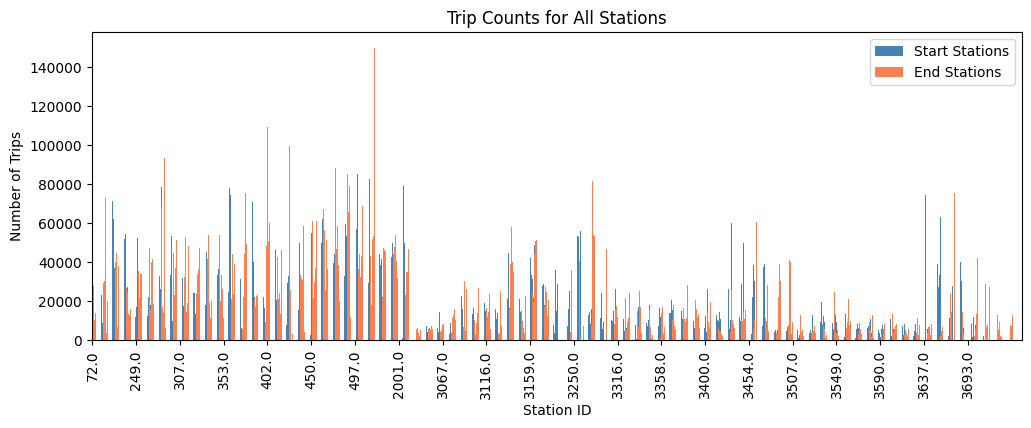

In [7]:
# Plotting the number of trips started and ended per station
plt.figure(figsize=(12, 4))

start_station_counts = data['start_station_id'].value_counts().sort_index()
end_station_counts = data['end_station_id'].value_counts().sort_index()

start_station_counts.plot(kind='bar', position=0, width=0.4, align='center', color='steelblue', legend=True)
end_station_counts.plot(kind='bar', position=1, width=0.4, align='edge', color='coral', legend=True)

plt.legend(['Start Stations', 'End Stations'])
plt.title('Trip Counts for All Stations')
plt.xlabel('Station ID')
plt.ylabel('Number of Trips')

tick_positions = range(0, len(start_station_counts), max(1, len(start_station_counts) // 20))
plt.xticks(tick_positions, [start_station_counts.index[i] if i < len(start_station_counts) else '' for i in tick_positions], rotation=90)

plt.show()


*CONCLUDE ON STATION ANALYSIS*

## 2.2 Bike Analysis

*WRITE INTRODUCTION TO SECTION 2.2*

We can also see which bikes are used the most:

In [8]:
# Computing statistics for the bikes
bike_data = data['bikeid'].value_counts().reset_index()

print(f"""
Bike statistics:
Number of bikes used: {len(bike_data)}
Range of station IDs: [{int(min(data['bikeid']))},{int(max(data['bikeid']))}]
Range of trip counts per bike: [{min(bike_data['count'])}, {max(bike_data['count'])}]
Mean: {bike_data['count'].mean():.2f}
STD: {bike_data['count'].std():.2f}
""")

# Top 10 most used bikes and their counts
bike_data[:10].T


Bike statistics:
Number of bikes used: 15244
Range of station IDs: [14529,35831]
Range of trip counts per bike: [1, 2862]
Mean: 1151.16
STD: 555.23



,0,1,2,3,4,5,6,7,8,9
bikeid,30657,32124,32090,32036,32541,32195,32606,30692,31108,30315
count,2862,2728,2707,2692,2681,2627,2593,2584,2576,2570


*DESCRIBE STATISTICS*

*CREATE TRANSITION TO BIKE DISTRIBUTION ANALYSIS*

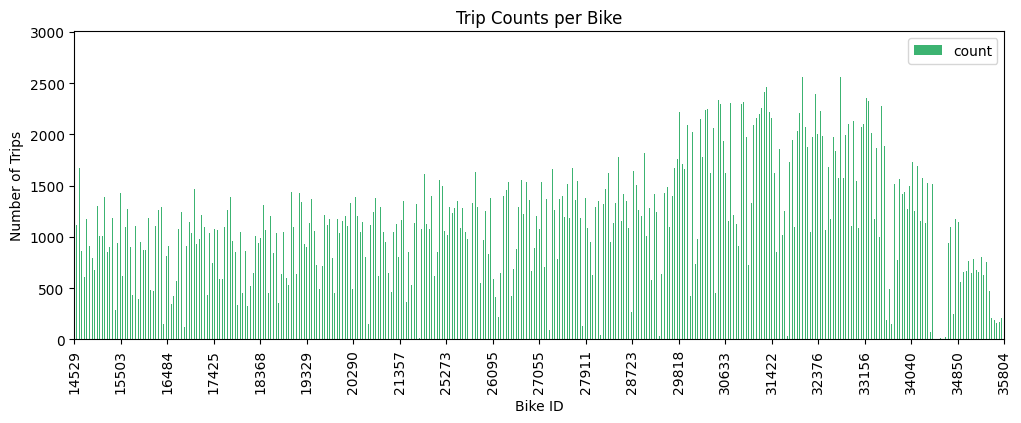

In [9]:
# Plotting the number of trips started and ended per station
plt.figure(figsize=(12, 4))

bikes = data['bikeid'].value_counts().sort_index()
bikes.plot(kind='bar', position=0, width=0.4, align='center', color='mediumseagreen', legend=True)

plt.title('Trip Counts per Bike')
plt.xlabel('Bike ID')
plt.ylabel('Number of Trips')

tick_positions = range(0, len(bikes), max(1, len(bikes) // 20))
plt.xticks(tick_positions, [bikes.index[i] if i < len(bikes) else '' for i in tick_positions], rotation=90)

plt.show()

*CONCLUDE ON BIKE ANALYSIS*

## 2.3 Trip Durations

*WRITE INTRODUCTION TO SECTION 2.3*

In [10]:
# TODO: ER DET SEKUNDER?
# Computing statistics for trip duration

print(f"""
Trip duration statistics:
Trip duration range (sec.): [{min(data['tripduration']):.2F}, {max(data['tripduration']):.2F}] (the latter being {max(data['tripduration']) / 60 / 60 / 24:.2F} days)
Mean: {data['tripduration'].mean():.2F}
Median: {data['tripduration'].median():.2F}
STD:  {data['tripduration'].std():.2F}
""")


Trip duration statistics:
Trip duration range (sec.): [61.00, 19510049.00] (the latter being 225.81 days)
Mean: 988.74
Median: 605.00
STD:  18895.84



Based on the summary statistics, it is noted that the maximum is much larger than both the mean and the median. Thus, it's likely that we have a few outlier trips, that are much longer than the rest. Converting the maximum trip-duration into days reveals that the trip lasted for 225 days - clearly an outlier.

Plotting the histogram, reveals that the trip durations is a very right-skewed distribution.
Therefore, the logarithm is applied to ease the visualization.

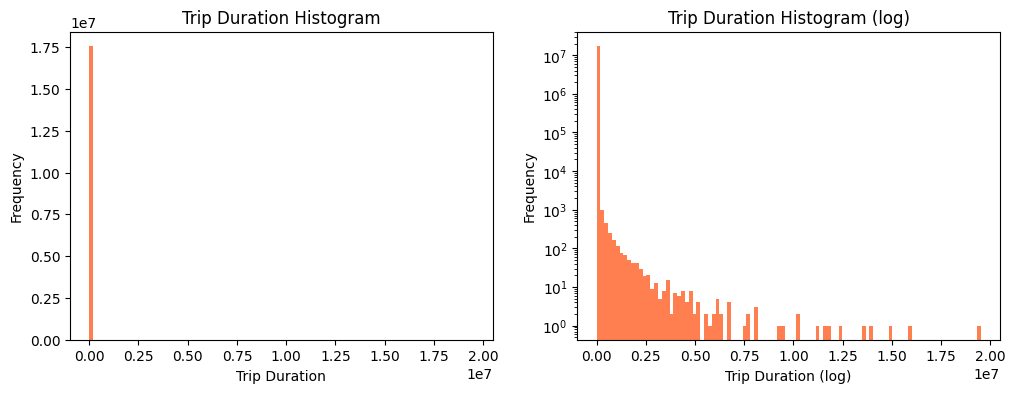

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(data['tripduration'], bins=100, color='coral')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')

plt.subplot(122)
plt.hist(data['tripduration'], bins=100, log=True, color='coral')
plt.xlabel('Trip Duration (log)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram (log)')
plt.show()

Based on the histograms and summary statistics, it's clear that some of these data points are outliers.

We decide to remove any data-point with trip durations lasting longer than the 99th percentile, by deeming them as outliers

*TODO: CHANGE THIS TO BE BASED ON WHAT WAS DEEMED OUTLIERS*

In [12]:
# Outlier if trip lasts more than a day
# data_outliers_removed = data[data['tripduration'] < 1*24*60*60]

# OR: remove if larger than third quartile:
# data_outliers_removed = data[data.tripduration < data.tripduration.quantile(0.75)]

# OR: remove if larger than 99th percentile
data_outliers_removed = data[data.tripduration < data.tripduration.quantile(0.99)]

print(f"Number of outliers removed from dataset: {len(data) - len(data_outliers_removed)}")

print(f"""
Cleaned trip duration statistics:
Trip duration range (seconds): [{min(data_outliers_removed['tripduration']):.2F}, {max(data_outliers_removed['tripduration']):.2F}] (the latter being {max(data_outliers_removed['tripduration']) / 60 / 60 / 24:.2F} days)
Mean: {data_outliers_removed['tripduration'].mean():.2F}
Median: {data_outliers_removed['tripduration'].median():.2F}
STD:  {data_outliers_removed['tripduration'].std():.2F}
""")

Number of outliers removed from dataset: 175529

Cleaned trip duration statistics:
Trip duration range (seconds): [61.00, 3506.00] (the latter being 0.04 days)
Mean: 776.70
Median: 599.00
STD:  576.11



Plotting the histogram reveals that the trip durations is still very right-skewed.
The logarithm however, is no longer needed.

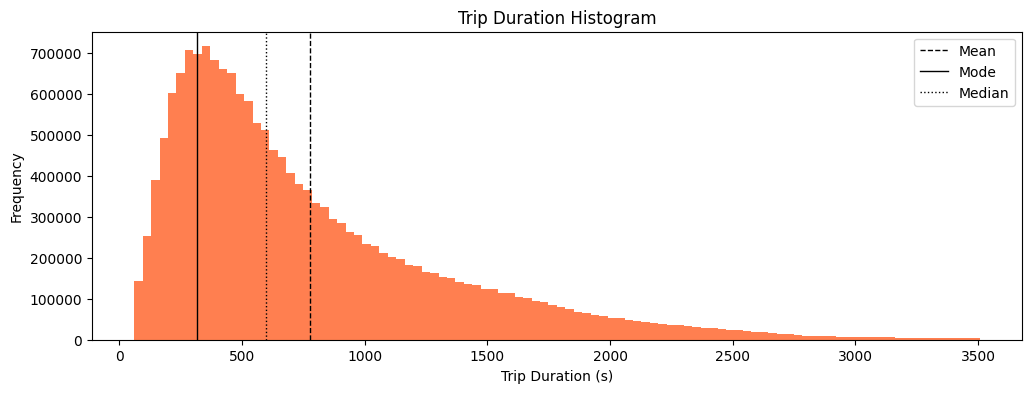

In [13]:
plt.figure(figsize=(12, 4))
plt.hist(data_outliers_removed['tripduration'], bins=100, color='coral')
plt.xlabel('Trip Duration (s)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')
plt.axvline(data_outliers_removed['tripduration'].mean(), color='k', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(float(data_outliers_removed['tripduration'].mode()), color='k', linestyle='-', linewidth=1, label='Mode')
plt.axvline(data_outliers_removed['tripduration'].median(), color='k', linestyle=':', linewidth=1, label='Median')
plt.legend()
plt.show()

# Trip count timeline
One could imagine that the amount of trips depends heavily on the time of year, day of week, as well as the time of day.

We start by creating a function for defining dataframes with trip-count information. Each row in the data-frame represents an hourly interval, with the number of pickups and dropoffs that happened in that hour.

In [14]:
# drop everything except starttime, stoptime, start_cluster, end_cluster
count_data = data_outliers_removed[['starttime', 'stoptime']]

# Floor starttime and stoptime to nearest hour
count_data['starttime'] = pd.to_datetime(count_data['starttime']).dt.floor('H')
count_data['stoptime'] = pd.to_datetime(count_data['stoptime']).dt.floor('H')

def create_dfs(df, cluster_id = None):
    """ Creates three dataframes:
    1. Pickups: All trips which started per hour-interval
    2. Dropoffs: All trips which ended per hour-interval
    3. Pickups and dropoffs: Merged dataframe of the above two dataframes

    :param df: The dataframe from which the dataframes should be created
    :param cluster_id: (Optional) If given, the cluster id for which the dataframes should be created
    :return: pickups, dropoffs, pickups_and_dropoffs
    
    """
    # Creating pickups dataframe - counting all trips which started in the highest volume cluster per hour-interval
    if cluster_id is not None:
        pickups = df[df['start_cluster'] == cluster_id]['starttime'].value_counts().reset_index()
    else:
        pickups = df['starttime'].value_counts().reset_index()
    pickups.columns = ['time', 'pickups']
    pickups = pickups.set_index('time')
    pickups.sort_index(inplace=True)

    # Drop-off dataframe - all trips which ended in the highest volume cluster per hour-interval
    if cluster_id is not None:
        dropoffs = df[df['end_cluster'] == cluster_id]['stoptime'].value_counts().reset_index()
    else:
        dropoffs = df['stoptime'].value_counts().reset_index()
    dropoffs.columns = ['time', 'dropoffs']
    dropoffs = dropoffs.set_index('time')
    dropoffs.sort_index(inplace=True)

    # merge dropoffs and pickups on index
    pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
    # replace NaN values associated with the merge with 0
    pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

    return pickups, dropoffs, pickups_and_dropoffs

pickups, dropoffs, pickups_and_dropoffs = create_dfs(count_data)


print(f"Sanity check: \n\t Total amount of pickups: {pickups['pickups'].sum()} \n\t Total amount of dropoffs: {dropoffs['dropoffs'].sum()}")

Sanity check: 
	 Total amount of pickups: 17372810 
	 Total amount of dropoffs: 17372810


In [15]:
# Adding weekday and month to df
pickups_and_dropoffs['weekday'] = [d.weekday() for d in pickups_and_dropoffs.index]
pickups_and_dropoffs['month'] = [d.month for d in pickups_and_dropoffs.index]

Plotting the amount of trips per month:

In [16]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'Oktober', 'November', 'December']

data = [go.Bar(
   x = months,
   y = [pickups_and_dropoffs[pickups_and_dropoffs['month'] == i+1]['pickups'].sum() for i, month in enumerate(months)]
)]
fig = go.Figure(data=data)
fig.show()

Perhaps not surprisingly, the hotter months are much more popular for bike-rides in NYC. 

Now for the weekdays:

In [17]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data = [go.Bar(
   x = days,
   y = [pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]['pickups'].sum() for i, day in enumerate(days)]
)]
fig = go.Figure(data=data)
fig.show()

The weekends have a noticeably lower amount of trips than the workdays, this could indicate that the bikes are used to get to and from work. 
Next, we plot the trip-count at an hourly interval, for all days of the week, to see if we can support this claim. 

In [19]:
# plotly plot
fig = go.Figure()

for i, weekday in enumerate(days):
    # Group data by hour of day
    weekdata = pickups_and_dropoffs[pickups_and_dropoffs['weekday'] == i]
    grouped_pickups_and_dropoffs = weekdata.groupby(weekdata.index.hour).sum()[["pickups", "dropoffs"]]


    fig.add_trace(go.Scatter(x=grouped_pickups_and_dropoffs.index, y=grouped_pickups_and_dropoffs['pickups'],
                        mode='lines',
                        name=f'{weekday}'))

    fig.update_layout(title='Pickups per weekday',
                        xaxis_title='Hour of day',
                        yaxis_title='Number of trips')

    # Vertical lines at 7am, 10am, 4pm and 7pm
    fig.add_shape(type="line",
                x0=7, y0=0, x1=7, y1=grouped_pickups_and_dropoffs.max().max(),
                line=dict(color="RoyalBlue", width=1, dash="dot"))
    fig.add_shape(type="line",
                    x0=10, y0=0, x1=10, y1=grouped_pickups_and_dropoffs.max().max(),
                    line=dict(color="RoyalBlue", width=1, dash="dot"))
    fig.add_shape(type="line",
                    x0=16, y0=0, x1=16, y1=grouped_pickups_and_dropoffs.max().max(),
                    line=dict(color="RoyalBlue", width=1, dash="dot"))
    fig.add_shape(type="line",
                    x0=19, y0=0, x1=19, y1=grouped_pickups_and_dropoffs.max().max(),
                    line=dict(color="RoyalBlue", width=1, dash="dot"))


fig.show()

Wow, very clear pattern in the data! It's observed that the peaks in data correspond to rush-hour, when New Yorkers get to and from work - while we see a completely different curve on weekends. 

These observations could be great to include as features in the coming prediction of pickups and dropoffs.

# Location analysis

*CONCLUDE ON DATA ANALYSIS AND PREPARATION SECTION*

In [20]:
# Distinct stations and their latitude / longitude
data_clustering = data_outliers_removed.drop_duplicates('start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
data_clustering.columns = [['station_id', 'latitude', 'longitude']]

We plot the location of the stations through a scatter plot

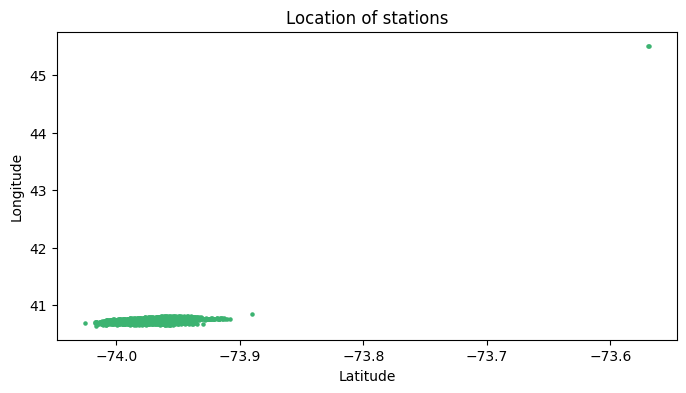

In [21]:
plt.figure(figsize=(8, 4))
plt.scatter(data_clustering['longitude'], data_clustering['latitude'], s=5, color='mediumseagreen')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Location of stations")
plt.show()

It seems some stations are located far from the rest, namely in Canada - these stations will be considered outliers from this point on. 

In [68]:
# Outlier stations
data_outliers_removed[data_outliers_removed['start_station_longitude'] > -73.8][data_outliers_removed['start_station_latitude'] > 45].groupby('start_station_id').count()

,tripduration,starttime,stoptime,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
start_station_id,,,,,,,,,,,,
3488.0,3,3,3,3,3,3,3,3,3,3,3,3
3650.0,67,67,67,67,67,67,67,67,67,67,67,67


In [69]:
# remove all rows with latitude < 45 and longitude < -73.8
data_outliers_removed = data_outliers_removed[data_outliers_removed['start_station_latitude'] < 45][data_outliers_removed['start_station_longitude'] < -73.8]
data_clustering = data_outliers_removed.drop_duplicates('start_station_id')[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
data_clustering.columns = [['station_id', 'latitude', 'longitude']]

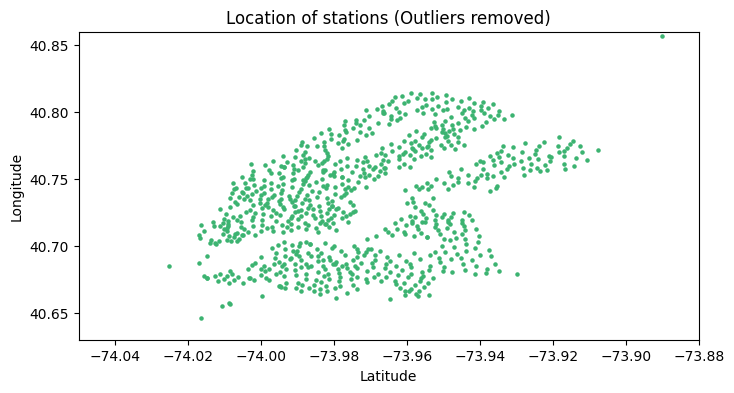

In [24]:
plt.figure(figsize=(8,4))
plt.scatter(data_clustering['longitude'], data_clustering['latitude'], s=5, color='mediumseagreen')
plt.ylim([40.63,40.86])
plt.xlim([-74.05,-73.88])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title("Location of stations (Outliers removed)")
plt.show()

*ANALYSIS*

In [25]:
vc_stations_start = data_outliers_removed.start_station_id.value_counts().reset_index()
vc_stations_end = data_outliers_removed.end_station_id.value_counts().reset_index()
vc_stations_start.columns = ['station_id', 'count']
vc_stations_end.columns = ['station_id', 'count']
long_lat_station_start = data_outliers_removed[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates('start_station_id')
long_lat_station_end = data_outliers_removed[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates('end_station_id')
long_lat_station_start.columns = ['station_id', 'latitude', 'longitude']
long_lat_station_end.columns = ['station_id', 'latitude', 'longitude']

vc_stations_start = vc_stations_start.merge(long_lat_station_start, on='station_id', how='left')
vc_stations_end = vc_stations_end.merge(long_lat_station_end, on='station_id', how='left')

# As Drake best said it, "Combination"
vc_stations = vc_stations_start.merge(vc_stations_end, on='station_id', how='inner')
vc_stations['count'] = vc_stations['count_x'] + vc_stations['count_y']
vc_stations.drop(['count_x', 'count_y', "latitude_y", "longitude_y"], axis=1, inplace=True)
vc_stations.columns = ['station_id', 'latitude', 'longitude', 'count']

In [26]:
# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Start Stations', 'End Stations'),
                    specs=[[{'type': 'mapbox'}, {'type': 'mapbox'}]],
                    horizontal_spacing=0.01)

# Add the start stations plot to the first subplot
fig.add_trace(go.Scattermapbox(
    lat=vc_stations_start['latitude'],
    lon=vc_stations_start['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=vc_stations_start['count'],
        color=vc_stations_start['count'],
        sizemode='area',
        sizeref=10.*max(vc_stations_start['count'])/(40.**2),
        sizemin=4
    ),
    text="Station Id: " + vc_stations_start['station_id'].astype(str) + "<br>" + "Count: " + vc_stations_start['count'].astype(str),
    hoverinfo='text',  # Display only the station ID on hover
), row=1, col=1)

# Add the end stations plot to the second subplot
fig.add_trace(go.Scattermapbox(
    lat=vc_stations_end['latitude'],
    lon=vc_stations_end['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=vc_stations_end['count'],
        color=vc_stations_end['count'],
        sizemode='area',
        sizeref=10.*max(vc_stations_end['count'])/(40.**2),
        sizemin=4
    ),
    text="Station Id: " + vc_stations_end['station_id'].astype(str) + "<br>" + "Count: " + vc_stations_end['count'].astype(str),
    hoverinfo='text',  # Display only the station ID on hover,
), row=1, col=2)

# Update layout with mapbox details
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=go.layout.mapbox.Center(lat=40.75, lon=-74),
        zoom=10
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=False,
)

# Update the layout for each subplot mapbox
for i in range(1, 3):
    fig.update_layout(
        **{
            f"mapbox{i}": {
                "style": "open-street-map",
                "center": {"lat": 40.75, "lon": -74},
                "zoom": 10
            }
        }
    )
# Show the figure
fig.show()

Above we see the volume of each start and end station. Here it is clear that one station, Station Id 519, has a much higher volumen than the rest. Albeit, this makes sense since it is Grand Central Station. Furthermore, from these plots there does seem to be a somewhat obvious clustering although not immediately apparent. It is pretty evident that the stations further from the center of the city have a lower volume, and vice versa.

# 3 Predictive Challenge

*WRITE INTRODUCTION TO SECTION 3*

FROM PROJECT DESCRIPTION:
For the prediction challenge, you are expected to predict the demand for the bike-sharing
system (number of dropoffs and pickups). You should do the predictions for clusters of
stations. This challenge consists of three tasks:

## 3.1 Spatial clustering of stations

*WRITE INTRODUCTION TO SECTION 3.1*

FROM PROJECT DESCRIPTION:
Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on the results of this
clustering, and analysis should be performed on at least one cluster (e.g., the one
with the largest demand). More is preferable.

-------------
Based on the map of the stations, and knowledge of the NYC grid-system, it's clear that there's some structural pattern to the placement of stations, where all seem to be quite evenly scattered across the map. 

This could indicate that a density-based clustering algorithm such as DBscan could face problems when clustering the stations based on longitude and latitude, as the arbitrary clustering shapes it can provide might work against it in this case. 

Moreover, the requirement of having at least 20 clusters further discourages the use of dbscan, as the number of clusters is not chosen, but rather optimized toward. This would require optimizing the hyperparameters of the algorithm based on having a minimum amount of clusters, which seems counter-intuitive. 

Therefore, we'll be clustering with K-means, as well as through Gaussian Mixtures (with Expectation-Maximization) as mentioned in the appendix of week 6.
As both algorithms has the number of clusters as a hyper-parameter, this will be used to optimize the clustering, and both will be evaluated wrt. their silhouette-score - as the distortion-score is not possible with GMM, as we need the centroids. 

### Clustering

We fit KMeans and GMM with n clusters ranging from 20-40 clusters, and calculate the silhouette score. Lastly, we plot the silhouette score of both in order to determine the best model for the clustering. 

In [109]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min

In [111]:
# Set the range of clusters to test
n_clusters_range = range(20, 41)

# Lists to store silhouette and distortion scores
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
distortion_scores_kmeans = []

# Loop over different values of n_clusters
for n_clusters in n_clusters_range:
    # KMeans
    km = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_labels = km.fit_predict(vc_stations[['latitude', 'longitude']])
    silhouette_kmeans = silhouette_score(vc_stations[['latitude', 'longitude']], kmeans_labels)
    distortion_kmeans = np.sum(pairwise_distances_argmin_min(vc_stations[['latitude', 'longitude']], km.cluster_centers_)[1])

    # Appending
    silhouette_scores_kmeans.append(silhouette_kmeans)
    distortion_scores_kmeans.append(distortion_kmeans)

    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    gmm_labels = gmm.fit_predict(vc_stations[['latitude', 'longitude']])
    silhouette_gmm = silhouette_score(vc_stations[['latitude', 'longitude']], gmm_labels)

    silhouette_scores_gmm.append(silhouette_gmm)

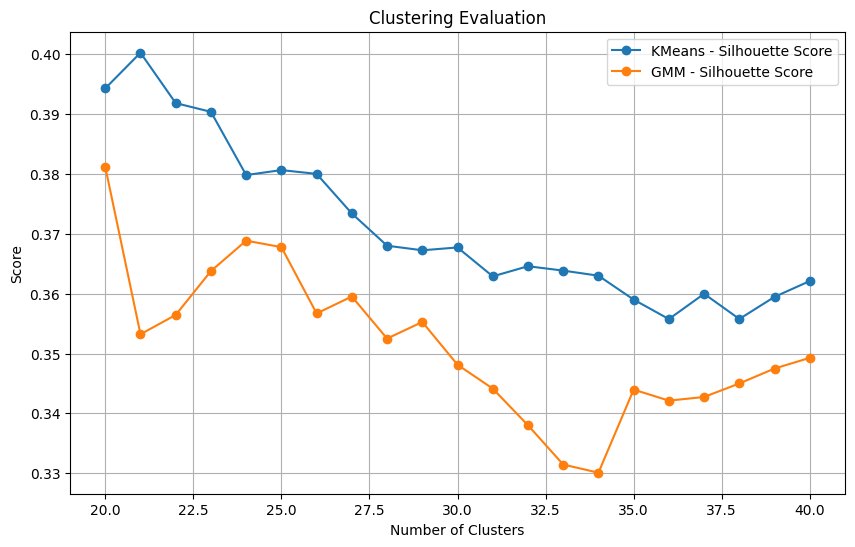

In [112]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot Silhouette Scores for KMeans
plt.plot(n_clusters_range, silhouette_scores_kmeans, marker='o', linestyle='-', label='KMeans - Silhouette Score')

# Plot Silhouette Scores for Gaussian Mixture Model
plt.plot(n_clusters_range, silhouette_scores_gmm, marker='o', linestyle='-', label='GMM - Silhouette Score')

plt.title('Clustering Evaluation')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Based on the silhouette scores, it's clear that KMeans performs better overall, with a maximum score of 0.4 - at 21 clusters. 

As the Silhouette score measures how similar an object is to it's own cluster compared to the second nearest cluster, on a scale from -1 to 1, it means that 0.4 is not an incredibly good score. 

However, based on the grid-system of NYC and the fact that these bike-stations are evenly scattered across the entire city, it would be really difficult to have well-separated clusters - as is also clearly apparent from the map, as the only easily visible clusters are the two giant clusters formed by having the East River running between Manhattan and Long Island. 

We'll plot the distortion score for the KMeans as well - that will give us an idea of the within-cluster variance.

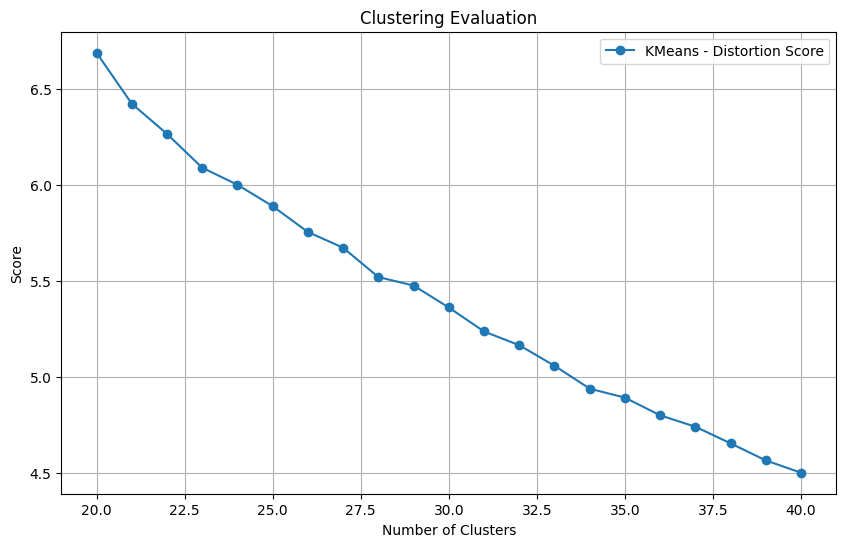

In [113]:
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot Silhouette Scores for KMeans
plt.plot(n_clusters_range, distortion_scores_kmeans, marker='o', linestyle='-', label='KMeans - Distortion Score')

plt.title('Clustering Evaluation')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Typically, one would look for the elbow in the Distortion plot - as more clusters will always allow for smaller, tighter clusters - and thereby lower within-cluster variance. However, one should look for elbow - as thats the point where adding more clusterrs won't decrease the distortion as much. 

However, on this plot there's no elbow - probably due to the structure of NYC, making it difficult to cluster the stations. 

Based on the two plots - we'll go with N = 21 clusters for the KMeans algorithm. 

In [114]:
km=KMeans(21, n_init='auto')
km.fit(vc_stations[['latitude', 'longitude']])
vc_stations['cluster'] = km.labels_

In [45]:
highest_vol_cluster = vc_stations.groupby('cluster')['count'].sum().reset_index().sort_values('count', ascending=False).iloc[0]['cluster']
print("Highest Volume Cluster: ",highest_vol_cluster)
df_high_vol_cluster = vc_stations[vc_stations['cluster'] == highest_vol_cluster]
print("Amount of stations in cluster: ",len(df_high_vol_cluster))
print("Amount of trips in cluster:", sum(df_high_vol_cluster["count"]))

Highest Volume Cluster:  19
Amount of stations in cluster:  49
Amount of trips in cluster: 4406299


We can now plot the points again, only this time we can color them based on their clustering.

In [46]:
# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Clustered', 'Highest Volume Cluster'),
                    specs=[[{'type': 'mapbox'}, {'type': 'mapbox'}]],
                    horizontal_spacing=0.01)

# Add the start stations plot to the first subplot
fig.add_trace(go.Scattermapbox(
    lat=vc_stations['latitude'],
    lon=vc_stations['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=6,
        color=vc_stations['cluster'],
        sizemode='area',
        sizemin=4
    ),
    text="Station Id: " + vc_stations['station_id'].astype(str) + "<br>" + "Count: " + vc_stations['count'].astype(str)
         + "<br>" + "Cluster: " + vc_stations['cluster'].astype(str),
    hoverinfo='text',  # Display only the station ID on hover
), row=1, col=1)

# Add the largest cluster stations plot to the second subplot
fig.add_trace(go.Scattermapbox(
    lat=df_high_vol_cluster['latitude'],
    lon=df_high_vol_cluster['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=6,
        color=df_high_vol_cluster['cluster'],
        sizemode='area',
        sizemin=4
    ),
    text="Station Id: " + df_high_vol_cluster['station_id'].astype(str) + "<br>" + "Count: " + df_high_vol_cluster['count'].astype(str)
         + "<br>" + "Cluster: " + df_high_vol_cluster['cluster'].astype(str),
    hoverinfo='text',  # Display only the station ID on hover
), row=1, col=2)


# Update layout with mapbox details
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(
        center=go.layout.mapbox.Center(lat=40.75, lon=-74),
        zoom=10
    ),
    margin={"r":0,"t":0,"l":0,"b":0},
    showlegend=False,
)

# Update the layout for each subplot mapbox
for i in range(1, 3):
    fig.update_layout(
        **{
            f"mapbox{i}": {
                "style": "open-street-map",
                "center": {"lat": 40.75, "lon": -74},
                "zoom": 10
            }
        }
    )
# Show the figure
fig.show()


Above we see the 20 different clusters on the map, left, and the largest cluster by volumne on the right. It was expected that the cluster with the Grand Central Station would be the cluster with highest volumen although it wasn't.

In [49]:
# Creating a dictionary which will help with translating the station ids to their cluster values in the original dataframe
station_to_cluster_dict = {row['station_id']: row['cluster'] for _, row in vc_stations.iterrows()}

In [50]:
data_outliers_removed['start_cluster'] = data_outliers_removed['start_station_id'].map(station_to_cluster_dict)
data_outliers_removed['end_cluster'] = data_outliers_removed['end_station_id'].map(station_to_cluster_dict)
data_outliers_removed.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,11.0,0.0
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,11.0,0.0
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,11.0,0.0
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,11.0,11.0
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,11.0,11.0


Based on the start and end clusters, we can now tell how often bikes move from cluster to cluster.

*TODO: we could also do analysis of which clusters are used moreso to travel within a cluster compared to from cluster to cluster*

In [88]:
print(f"""Amount of trips starting and ending in the same cluster: {len(data_outliers_removed[data_outliers_removed['start_cluster'] == data_outliers_removed['end_cluster']])}
Amount of trips starting and ending in different clusters: {len(data_outliers_removed[data_outliers_removed['start_cluster'] != data_outliers_removed['end_cluster']])}""")

Amount of trips starting and ending in the same cluster: 6756070
Amount of trips starting and ending in different clusters: 10616670


## 3.2 Predicting the Demand for a Cluster of Stations

FROM PROJECT DESCRIPTION: 
You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look like for the next day (e.g., given demand data until midnight of day 1, predict the number of pickups for all 1h intervals [6-7am, 7-8am, ..., 11-12pm] in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the departures (pickups). You should use a time aggregation of one hour or less. You can choose to use two
different models or a single one to predict both. It is up to you to decide how to best formulate this problem as a machine learning problem. You should not shuffle the
data. You should instead use the data from January to October (included) to train your model, and the data from November and December as a test set. As a reference, good model should be able to predict the test set with an R2 of at least 0.60. You can use any sklearn regression model you want.

------------

In order to predict both the pickups and dropoff within the cluster at any time-point, we need to do some data wrangling in order to get our observations. 
Each observation should contain a timepoint, as well as the number of pickups and dropoffs that happened in the hour following the time-point.

We'll use the function defined earlier, for the cluster with the highest volume.

In [51]:
# drop everything except starttime, stoptime, start_cluster, end_cluster
data_high_vol_cluster = data_outliers_removed[['starttime', 'stoptime', 'start_cluster', 'end_cluster']]

# Floor starttime and stoptime to nearest hour
data_high_vol_cluster['starttime'] = pd.to_datetime(data_high_vol_cluster['starttime']).dt.floor('H')
data_high_vol_cluster['stoptime'] = pd.to_datetime(data_high_vol_cluster['stoptime']).dt.floor('H')

pickups, dropoffs, pickups_and_dropoffs = create_dfs(data_high_vol_cluster, highest_vol_cluster)


print(f"Sanity check: \n\t Total amount of pickups: {pickups['pickups'].sum()} \n\t Total amount of dropoffs: {dropoffs['dropoffs'].sum()}")

Sanity check: 
	 Total amount of pickups: 2180649 
	 Total amount of dropoffs: 2225650


In [52]:
pickups_and_dropoffs

,pickups,dropoffs
time,,
2018-01-01 00:00:00,14.0,10.0
2018-01-01 01:00:00,28.0,14.0
2018-01-01 02:00:00,8.0,8.0
2018-01-01 03:00:00,6.0,11.0
2018-01-01 04:00:00,4.0,6.0
...,...,...
2018-12-31 20:00:00,14.0,17.0
2018-12-31 21:00:00,10.0,10.0
2018-12-31 22:00:00,3.0,12.0


In [53]:
sum(pickups_and_dropoffs['pickups'] + pickups_and_dropoffs['dropoffs'])

4406299.0

With the dataframe defined we can construct our lagged features.
For this project we chose to create the following 3 laggged features:
- Lagged demand 1 hour back
- Lagged demand 24 hours back
- Lagged demand 168 hours back

For the lagged demand 1 hour back, we have to note that this means our predictions will be dependent on the previous hour. This is not ideal, but we will still use it as a feature.

Additionally, baseed on the exploratory analysis, we will create features for **rushhour**, **weekend**, **summer** and **holiday** to see if these have an impact on the demand. Intuitively, these have a significant effect on our own travel patterns, so it is likely that they will also have an effect on the demand for bikes. Based on the plots from earlier, we deem reasonable rushour intervals to be 7am-10am and 4pm-7pm.

Since we will have to model this for each cluster, we create a class that is able to do all of this for us. 

Depending on the input-parameters, the model will either be a **Linear Regression** model, acting as a baseline, or a **Random Forest Regressor**.
**TODO: SOME MORE INFO HERE PROBABLY**

Also, why not standardization? --> All features are within similar ranges

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

class ClusterBuster:
    """Class to model the demand.
    """
    def __init__(self, cluster_id, cluster_df, baseline = False, print_info=True):
        """Initialize the ClusterBuster object.

        :param cluster_id: The cluster id for which the object should be created
        :param cluster_df: The dataframe for the cluster id
        """
        self.cluster_id = cluster_id
        self.cluster_df = cluster_df[['starttime', 'stoptime', 'start_cluster', 'end_cluster']]
        self.model_dropoffs = None
        self.model_pickups = None
        self.pickups = None
        self.dropoffs = None
        self.X_p = None
        self.y_p = None
        self.X_d = None
        self.y_d = None
        self.pred_pickups = None
        self.pred_dropoffs = None
        self.pickups_test = None
        self.dropoffs_test = None
        self.linear_model_metrics = None
        self.print_info = print_info
        self.baseline = baseline
        
        if self.print_info:
            print(f"ClusterBuster object created for cluster {cluster_id}")
        # Floor starttime and stoptime to nearest hour
        self.cluster_df['starttime'] = pd.to_datetime(self.cluster_df['starttime']).dt.floor('H')
        self.cluster_df['stoptime'] = pd.to_datetime(self.cluster_df['stoptime']).dt.floor('H')

        # Creating pickups dataframe - counting all trips which started in the highest volume cluster per hour-interval
        pickups = self.cluster_df[self.cluster_df['start_cluster'] == self.cluster_id]['starttime'].value_counts().reset_index()
        pickups.columns = ['time', 'pickups']
        pickups = pickups.set_index('time')
        pickups.sort_index(inplace=True)

        # Drop-off dataframe - all trips which ended in the highest volume cluster per hour-interval
        dropoffs = self.cluster_df[self.cluster_df['end_cluster'] == self.cluster_id]['stoptime'].value_counts().reset_index()
        dropoffs.columns = ['time', 'dropoffs']
        dropoffs = dropoffs.set_index('time')
        dropoffs.sort_index(inplace=True)

        # merge dropoffs and pickups on index
        pickups_and_dropoffs = pickups.merge(dropoffs, left_index=True, right_index=True, how='outer')
        # replace NaN values associated with the merge with 0
        pickups_and_dropoffs = pickups_and_dropoffs.fillna(0)

        self.pickups_and_dropoffs = pickups_and_dropoffs

    def create_features(self, include = ['rushhour', 'weekend', 'summer', 'holiday']):
        """Creates features for the cluster dataframe.
        """

        # Create new feature columns
        if self.print_info:
            print("Creating lag features")
        self.pickups_and_dropoffs['1hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(1)
        self.pickups_and_dropoffs['24hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(24)
        self.pickups_and_dropoffs['168hLagPickups'] = self.pickups_and_dropoffs['pickups'].shift(168)

        self.pickups_and_dropoffs['1hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(1)
        self.pickups_and_dropoffs['24hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(24)
        self.pickups_and_dropoffs['168hLagDropoffs'] = self.pickups_and_dropoffs['dropoffs'].shift(168)

        self.pickups_and_dropoffs.replace(np.nan, 0, inplace=True)

        # Create feature for rushhour or not - defined as 7-10 and 16-19
        if 'rushhour' in include:
            if self.print_info:
                print("Creating rushhour feature")
            self.pickups_and_dropoffs['rushhour'] = 0
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.hour >= 7) & (self.pickups_and_dropoffs.index.hour <= 10), 'rushhour'] = 1
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.hour >= 16) & (self.pickups_and_dropoffs.index.hour <= 19), 'rushhour'] = 1

        if 'weekend' in include:
            # Create feature for weekend or not - defined as 5-6
            if self.print_info:
                print("Creating weekend feature")
            self.pickups_and_dropoffs['weekend'] = 0
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.dayofweek >= 5), 'weekend'] = 1

        if 'summer' in include:
            # Create feature for hotter-months (April-September)
            if self.print_info:
                print("Creating summer feature")
            self.pickups_and_dropoffs['summer'] = 0
            self.pickups_and_dropoffs.loc[(self.pickups_and_dropoffs.index.month >= 4) & (self.pickups_and_dropoffs.index.month <= 9), 'summer'] = 1

        if 'holiday' in include:
            # add holiday feature
            if self.print_info:
                print("Creating holiday feature")
            self.pickups_and_dropoffs['holiday'] = 0
            us_holidays = holidays.UnitedStates()

            # we have hours in index so we need to convert to date
            self.pickups_and_dropoffs['date'] = self.pickups_and_dropoffs.index.date

            # iterate over all dates and check if it is a holiday
            for date in self.pickups_and_dropoffs['date'].unique():
                if date in us_holidays:
                    self.pickups_and_dropoffs.loc[self.pickups_and_dropoffs['date'] == date, 'holiday'] = 1

            # drop date column
            self.pickups_and_dropoffs.drop('date', axis=1, inplace=True)

        # .......................................................

        # All features except pickups and dropoffs
        self.features = self.pickups_and_dropoffs.columns.drop(['pickups', 'dropoffs'])

        if self.print_info:
            print(f"Features created for cluster {self.cluster_id}")
            print(f"Features: {self.features}")

        self.pickups = self.pickups_and_dropoffs[["pickups"] + list(self.features)]
        self.dropoffs = self.pickups_and_dropoffs[["dropoffs"] + list(self.features)]
        
        self.pickups_train = self.pickups.loc[(self.pickups.index.month >= 1) & (self.pickups.index.month <= 10)]
        self.pickups_test = self.pickups.loc[(self.pickups.index.month >= 11) & (self.pickups.index.month <= 12)]

        self.dropoffs_train = self.dropoffs.loc[(self.dropoffs.index.month >= 1) & (self.dropoffs.index.month <= 10)]
        self.dropoffs_test = self.dropoffs.loc[(self.dropoffs.index.month >= 11) & (self.dropoffs.index.month <= 12)]

        self.X_p = self.pickups_train[self.features]
        self.y_p = self.pickups_train["pickups"]

        self.X_d = self.dropoffs_train[self.features]
        self.y_d = self.dropoffs_train["dropoffs"]

    def create_model(self):
        """Creates an RF model for the cluster dataframe. or a baseline Logistic Regression model.
        """
        if self.baseline:
            self.model_pickups = LinearRegression()
            self.model_dropoffs = LinearRegression()

        else:
            self.model_pickups = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
            self.model_dropoffs = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

        if self.print_info:
            print("="*50)
            print(f"Models created for cluster {self.cluster_id}")
            print("Fitting for pickups and dropoffs...")
        
        self.model_pickups.fit(self.X_p, self.y_p)
        self.model_dropoffs.fit(self.X_d, self.y_d)
        
        if self.print_info:
            print("Models fitted")
            print("="*50)

    def predict(self):
        """Predicts the demand for the cluster dataframe.
        """
        self.pred_pickups = self.model_pickups.predict(self.pickups_test[self.features])
        self.pred_dropoffs = self.model_dropoffs.predict(self.dropoffs_test[self.features])

    def metrics(self):
        """Returns the metrics for the cluster dataframe.
        """
        from sklearn.metrics import mean_squared_error, mean_absolute_error

        metrics = {
            "pickups": {
                "MSE": mean_squared_error(self.pickups_test["pickups"], self.pred_pickups),
                "MAE": mean_absolute_error(self.pickups_test["pickups"], self.pred_pickups),
                "R2": self.model_pickups.score(self.X_p, self.y_p)
            },
            "dropoffs": {
                "MSE": mean_squared_error(self.dropoffs_test["dropoffs"], self.pred_dropoffs),
                "MAE": mean_absolute_error(self.dropoffs_test["dropoffs"], self.pred_dropoffs),
                "R2": self.model_dropoffs.score(self.X_d, self.y_d)
            }
        }
        return metrics



We start by creating the class for the highest volume cluster.
And print the dataframe as it would look once including all features, namely the lag as well as the boolean features for rushhour, weekend, summer and holiday.

In [100]:
cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed)
cluster_buster.create_features()
cluster_buster.pickups_and_dropoffs

ClusterBuster object created for cluster 19
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 19
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer',
       'holiday'],
      dtype='object')


,pickups,dropoffs,1hLagPickups,24hLagPickups,168hLagPickups,1hLagDropoffs,24hLagDropoffs,168hLagDropoffs,rushhour,weekend,summer,holiday
time,,,,,,,,,,,,
2018-01-01 00:00:00,14.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
2018-01-01 01:00:00,28.0,14.0,14.0,0.0,0.0,10.0,0.0,0.0,0,0,0,1
2018-01-01 02:00:00,8.0,8.0,28.0,0.0,0.0,14.0,0.0,0.0,0,0,0,1
2018-01-01 03:00:00,6.0,11.0,8.0,0.0,0.0,8.0,0.0,0.0,0,0,0,1
2018-01-01 04:00:00,4.0,6.0,6.0,0.0,0.0,11.0,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00,14.0,17.0,23.0,90.0,36.0,24.0,94.0,40.0,0,0,0,0
2018-12-31 21:00:00,10.0,10.0,14.0,68.0,29.0,17.0,69.0,28.0,0,0,0,0
2018-12-31 22:00:00,3.0,12.0,10.0,71.0,24.0,10.0,55.0,20.0,0,0,0,0


Firstly, we train and evaluate our baseline - the Linear Regression model. 

We train and evaluate with all of the extra features, rushhour, summer, weekend, holiday. 

In [106]:
# With no extra features (only lag features)
lin_reg = ClusterBuster(highest_vol_cluster, data_outliers_removed, baseline=True)
lin_reg.create_features()
lin_reg.create_model()
lin_reg.predict()
metrics = lin_reg.metrics()
metrics

ClusterBuster object created for cluster 19
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 19
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer',
       'holiday'],
      dtype='object')
Models created for cluster 19
Fitting for pickups and dropoffs...
Models fitted


{'pickups': {'MSE': 4987.53770758822,
  'MAE': 47.94246421955997,
  'R2': 0.8828252108694847},
 'dropoffs': {'MSE': 5091.160569441378,
  'MAE': 48.133455860349294,
  'R2': 0.8860077371618138}}

The baseline, Linear Regression model receives an **R^2-score of 0.883** for **pickups**, and **R^2-score of 0.886** for **dropoffs**.

Which is quite impressive, but as it is the simplest of models, we assume we can find a better performance in a Random Forest Regressor. 

In order to optimize the RF regressor, we'll start by including *none* of the extra features, only lag. 
Then, step-by-step, we'll start to include features, in order to see if the feature has a positive or negative impact on the model-performance. 

In [116]:
# With no extra features (only lag features)
cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed)
cluster_buster.create_features(include = [])
cluster_buster.create_model()
cluster_buster.predict()
metrics = cluster_buster.metrics()
metrics

ClusterBuster object created for cluster 19
Creating lag features
Features created for cluster 19
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs'],
      dtype='object')
Models created for cluster 19
Fitting for pickups and dropoffs...
Models fitted


{'pickups': {'MSE': 3645.4611699024526,
  'MAE': 38.483579388213755,
  'R2': 0.9651237086920473},
 'dropoffs': {'MSE': 3574.2305418677765,
  'MAE': 38.14233357678908,
  'R2': 0.9688116214105782}}

With just lag features, the Random Forest Regressor receives a **R^2-score of 0.965** for **pickups**, and **R^2-score of 0.969** for **dropoffs**.

This is already very good results, we begin including features.

In [117]:
best_pickups_r2  = metrics['pickups']['R2']
best_dropoffs_r2 = metrics['dropoffs']['R2']

print(f"No extra features (only lag features): \n\tPickups:{best_pickups_r2}\n\tDropoffs:{best_dropoffs_r2}")

# Ablation study, exclude features ([holiday, weekend, rushhour, summer]) one by one, and see how the model performs
# Create a list with all features
features = ['rushhour', 'weekend', 'summer', 'holiday']
# ablation study - for loop, exclude feature, measure performance
included_features = []
for feature in features:
    print("\nNow trying feature: ", feature)
    cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed, print_info=False)
    # Excluding feature, as well as all excluded features
    cluster_buster.create_features(include=[feature]+included_features)
    cluster_buster.create_model()
    cluster_buster.predict()
    metrics = cluster_buster.metrics()

    if best_pickups_r2 < metrics['pickups']['R2']:
        best_pickups_r2 = metrics['pickups']['R2']
        included_features.append(feature)
        print(f"\t Pickups R2 improved to {best_pickups_r2}, including features {included_features} from now on")

    if best_dropoffs_r2 < metrics['dropoffs']['R2']:
        best_dropoffs_r2 = metrics['dropoffs']['R2']
        # included_features.append(feature)
        print(f"\t Dropoff R2 improved to {best_dropoffs_r2}")      
        print(metrics)  


No extra features (only lag features): 
	Pickups:0.9651237086920473
	Dropoffs:0.9688116214105782

Now trying feature:  rushhour
	 Pickups R2 improved to 0.9680209319109202, including features ['rushhour'] from now on
	 Dropoff R2 improved to 0.971699000478729
{'pickups': {'MSE': 3482.424079919381, 'MAE': 36.55141998392957, 'R2': 0.9680209319109202}, 'dropoffs': {'MSE': 3358.645041340532, 'MAE': 36.600491962312724, 'R2': 0.971699000478729}}

Now trying feature:  weekend
	 Pickups R2 improved to 0.9705847745454965, including features ['rushhour', 'weekend'] from now on
	 Dropoff R2 improved to 0.9731678840298943
{'pickups': {'MSE': 3277.884339962864, 'MAE': 35.65478741020274, 'R2': 0.9705847745454965}, 'dropoffs': {'MSE': 3232.4304396634006, 'MAE': 36.02403597863397, 'R2': 0.9731678840298943}}

Now trying feature:  summer
	 Pickups R2 improved to 0.9709168715158308, including features ['rushhour', 'weekend', 'summer'] from now on
	 Dropoff R2 improved to 0.9734215291291948
{'pickups': {'

As seen, though the model already had surprisingly good performance - each extra feature increased the performance a slight bit more.

With all features, the Random Forest Regressor receives a **R^2-score of 0.971** for **pickups**, and **R^2-score of 0.973** for **dropoffs**.

---------
Below is a table summarizing the findings:
|                                              | R2 - pickups | MSE - pickups | R2 - dropoffs | MSE - dropoffs |
|----------------------------------------------|--------------|---------------|---------------|----------------|
| **Baseline**                                 | 0.883        | 4987.538      | 0.886         | 5091.161       |
| **RFR** []                                   | 0.965        | 3645.461      | 0.969         | 3574.231       |
| **RFR** [rushhour]                           | 0.968        | 3482.424      | 0.972         | 3358.645       |
| **RFR** [rushhour, weekend]                  | 0.971        | 3277.884      | 0.973         | 3232.430       |
| **RFR** [rushhour, weekend, summer]          | 0.971        | **3176.690**  | 0.973         | **3176.468**   |
| **RFR** [rushhour, weekend, summer, holiday] | **0.971**    | 3193.131      | **0.973**     | 3184.030       |

As seen, including *all features* is best in terms of R^2 score, however, not including holidays has a better MSE, while being just *slightly* below in R^2 - which is why we're deeming that to be the best model. 

In [118]:
# With no extra features (only lag features)
cluster_buster = ClusterBuster(highest_vol_cluster, data_outliers_removed, print_info=False)
cluster_buster.create_features(include = [])
cluster_buster.create_model()
cluster_buster.predict()
metrics = cluster_buster.metrics()
metrics

# plot predictions using plotly

fig = make_subplots(rows=1, cols=2,
                    horizontal_spacing=0.1)

# Add the start stations plot to the first subplot
fig.add_trace(go.Scatter(
    x=pickups.index,
    y=pickups['pickups'],
    mode='markers',
    name='Actual Pickups'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=cluster_buster.pickups_test.index,
    y=cluster_buster.pred_pickups,
    mode='markers',
    name='Predicted Pickups'
), row=1, col=1)

# Add the end stations plot to the second subplot
fig.add_trace(go.Scatter(
    x=dropoffs.index,
    y=dropoffs['dropoffs'],
    mode='markers',
    name='Actual Dropoffs'
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=cluster_buster.dropoffs_test.index,
    y=cluster_buster.pred_dropoffs,
    mode='markers',
    name='Predicted Dropoffs'
), row=1, col=2)

fig.update_layout(title='Predicted pickups vs actual pickups',
                     xaxis_title='Time',
                     yaxis_title='Pickups')

fig.show()

It might not intially be obvious, but zooming in we can see there is a pretty clear cyclical pattern in the demand. This is likely due to the fact that the demand is higher during the day than during the night. Plotting the predicted as a function of the predictions we see that the predictions are somewhat good.

In [91]:
fig = make_subplots(rows=2, cols=2,
                    horizontal_spacing=0.1,
                    vertical_spacing=0.1,
                    subplot_titles=('Predicted pickups vs actual pickups', 'Predicted dropoffs vs actual dropoffs',
                                    'Residuals pickups', 'Residuals dropoffs')
                    )

# Add the start stations plot to the first subplot
fig.add_trace(go.Scatter(
    x=cluster_buster.pred_pickups,
    y=cluster_buster.pickups_test['pickups'],
    mode='markers',
    name='True vs Pred'
), row=1, col=1)

# Add the end stations plot to the second subplot
fig.add_trace(go.Scatter(
    x=cluster_buster.pred_dropoffs,
    y=cluster_buster.dropoffs_test['dropoffs'],
    mode='markers',
    name='True vs Pred'
), row=1, col=2)

# add line of perfect fit
fig.add_trace(go.Scatter(
    x=[0, 1500],
    y=[0, 1500],
    mode='lines',
    name='Perfect fit'
), row=1, col=1)

# add line of perfect fit
fig.add_trace(go.Scatter(
    x=[0, 1500],
    y=[0, 1500],
    mode='lines',
    name='Perfect fit'
), row=1, col=2)

# add residuals histogram
fig.add_trace(go.Histogram(
    x=cluster_buster.pickups_test['pickups'] - cluster_buster.pred_pickups,
    name='Residuals Pickups'
), row=2, col=1)

# add residuals histogram
fig.add_trace(go.Histogram(
    x=cluster_buster.dropoffs_test['dropoffs'] - cluster_buster.pred_dropoffs,
    name='Residuals Dropoffs'
), row=2, col=2)

# update size
fig.update_layout(title='Actual vs predicted pickups and dropoffs',
                        xaxis_title='Predicted',
                        yaxis_title='Actual',
                        width=1100,
                        height=800)

fig.show()


## 3.3 Bike Requirements for Station Clusters

FROM PROJECT DESCRIPTION:
Overnight, the bike-sharing company manually repositions their bikes in order to ensure that the demand for the next day can be satisfied. You are expected to use the outputs from the prediction model above to compute the required number of bicycles to be placed in each cluster of stations analyzed in Task 2 at the beginning of the next day. To compute this number, you can use the cumulative of the arrivals and departures. The goal is to ensure that, over the duration of the next day, there will never be a shortage of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The number of bicycles required can be extrapolated as the maximum difference between departures and arrivals.

In [92]:
# Create a list of all cluster ids
cluster_ids = list(data_outliers_removed['start_cluster'].unique())
# Remove last because it is nan apparently
cluster_ids = cluster_ids[:-1]
cluster_df_sd = pd.DataFrame(index=cluster_ids)

# create columns with dates from start november to end december
dates = pd.date_range(start='2018-11-01', end='2018-12-31', freq='D')
for date in dates:
    cluster_df_sd[date] = 0
cluster_df_sd

,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,...,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31
11.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# We create a dataframe with cluster ids as index and the surplus_deficit for each date as columns
for idx, cluster_id in enumerate(cluster_ids):
    cluster_buster = ClusterBuster(cluster_id, data_outliers_removed)
    cluster_buster.create_features()
    cluster_buster.create_model()
    cluster_buster.predict()
    pred_dropoffs_date = cluster_buster.dropoffs_test.groupby(cluster_buster.dropoffs_test.index.date).sum()
    pred_pickups_date = cluster_buster.pickups_test.groupby(cluster_buster.pickups_test.index.date).sum()
    # Group and sum the predicted pickups and dropoffs per day
    diffs = pred_dropoffs_date['dropoffs'] - pred_pickups_date['pickups'] # Income - outcome
    # ensure diffs has the same length as dates
    diffs = diffs.reindex(dates, fill_value=0)
    cluster_df_sd.iloc[idx] = diffs

ClusterBuster object created for cluster 11.0
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 11.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer',
       'holiday'],
      dtype='object')
Models created for cluster 11.0
Fitting for pickups and dropoffs...
Models fitted
ClusterBuster object created for cluster 6.0
Creating lag features
Creating rushhour feature
Creating weekend feature
Creating summer feature
Creating holiday feature
Features created for cluster 6.0
Features: Index(['1hLagPickups', '24hLagPickups', '168hLagPickups', '1hLagDropoffs',
       '24hLagDropoffs', '168hLagDropoffs', 'rushhour', 'weekend', 'summer',
       'holiday'],
      dtype='object')
Models created for cluster 6.0
Fitting for pickups and dropoffs...
Models fitted
ClusterBuster object created 

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by RandomForestRegressor.

In [ ]:
cluster_df_sd

# 4 Exploratory challenge

The initial analysis of and predictive challenge with the Citi Bike dataset has investigated the possibility of predicting station bike demands in order to accurately reposition bikes overnight. This section will investigate whether future stations' popularity - comparable to its demands - can be accurately classified based on its proximity to points of interest (POIs). Essentially, exploring the research question:

<center><strong>Can the Proximity to Points of Interest Accurately Classify the Popularity of Bike-Sharing Stations?</strong></center>

This involves establishing a popularity baseline through clustering stations based on overall demand, fetching POI data and extending the dataset with proximity to POI features, applying dimensionality reduction to isolate key features, and lastly training, testing and evaluating a classifier. If the investigation proves that POIs can be used to predict a station's popularity, the classifier would be a great decision-aiding tool for when Citi Bike expands with stations in New York or other cities.


## 4.1 Clustering Stations based on Popularity

Before exploring the influence of POIs on station usage, a baseline of current station popularity must be established for benchmarking - and should reveal patterns within the Citi Bike network. This will be done through K-means clustering on the bike sharing data where stations will be clustered into *low*, *medium* or *high* popularity based on the sation's usage.

The pre-processed data from above is again used with the previously found clusters removed:

In [120]:
# Fetch cleaned data
data_clean = data_outliers_removed.copy()
data_clean.drop(columns=['start_cluster', 'end_cluster'], inplace=True)
data_clean.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


The number of times the stations have been used as either a start- or end-station can be calculated and summed to find their total usage in 2018:

In [121]:
def get_station_usage(df):
    # Count the number of starts and stops at each station
    start_counts = df['start_station_id'].value_counts().reset_index()
    start_counts.columns = ['station_id', 'start_count']

    end_counts = df['end_station_id'].value_counts().reset_index()
    end_counts.columns = ['station_id', 'end_count']

    # Merge the start and end counts
    station_usage = pd.merge(start_counts, end_counts, on='station_id', how='outer').fillna(0)

    # Calculate total usage for each station
    station_usage['total_usage'] = station_usage['start_count'] + station_usage['end_count']

    return station_usage

In [122]:
# Calculate station usage
station_usage = get_station_usage(data_clean)
station_usage.head()

,station_id,start_count,end_count,total_usage
0,519.0,149660.0,149359,299019.0
1,497.0,108405.0,112879,221284.0
2,435.0,106857.0,108402,215259.0
3,402.0,105141.0,108747,213888.0
4,426.0,93387.0,98261,191648.0


By plotting a histogram of the total station usage, insights into the distribution can help indentify potential outliers:

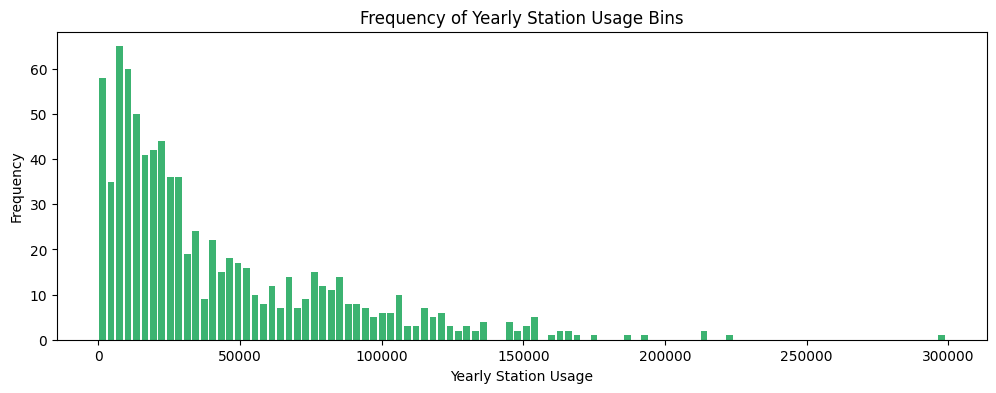

In [123]:
# Plot histogram of total station usage
plt.figure(figsize=(12, 4))
plt.hist(station_usage['total_usage'], bins=100, color='mediumseagreen', rwidth=0.8)
plt.xlabel('Yearly Station Usage')
plt.ylabel('Frequency')
plt.title('Frequency of Yearly Station Usage Bins')
plt.show()

The station usage is left-skewed and holds some distinct outliers with usage above 200,000; their validity will be inspected by plotting them on a map of New York to see if they are in central areas. To do this, latitude and longitude for each station is inserted in the `station_usage` dataframe:


In [124]:
# Extract unique stations from start and end station IDs
unique_stations = pd.concat([
    data_clean[['start_station_id', 'start_station_latitude', 'start_station_longitude']].rename(columns={'start_station_id': 'station_id', 'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'}),
    data_clean[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(columns={'end_station_id': 'station_id', 'end_station_latitude': 'latitude', 'end_station_longitude': 'longitude'})
]).drop_duplicates('station_id')

# Merge latitude and longitude information into station_usage dataframe
station_usage = station_usage.merge(unique_stations, how='left', left_on='station_id', right_on='station_id')
station_usage.head()

,station_id,start_count,end_count,total_usage,latitude,longitude
0,519.0,149660.0,149359,299019.0,40.751873,-73.977706
1,497.0,108405.0,112879,221284.0,40.737050,-73.990093
2,435.0,106857.0,108402,215259.0,40.741740,-73.994156
3,402.0,105141.0,108747,213888.0,40.740343,-73.989551
4,426.0,93387.0,98261,191648.0,40.717548,-74.013221


The stations with usage higher than 200,000 are then extracted and plotted using the `single_map_plotter` function in Appendix B:

In [125]:
# Filter the stations with more than 200,000 yearly uses
top_stations = station_usage[station_usage['total_usage'] > 200000]

# Prepare data for plotting and plot
plot_data = top_stations.copy()
TITLE = 'Outlier Stations by Usage'
LAT = plot_data['latitude']
LON = plot_data['longitude']
COLOR = plot_data['total_usage']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Total Usage: " + plot_data['total_usage'].astype(str)

single_map_plotter(TITLE, LAT, LON, COLOR, TEXT, ZOOM=12, SIZE=15)


From the plot it is seen that the heaviest outlier with close to 300,000 trip-starts and -ends per year is located by Grand Central Terminal while the others are placed centrally on Broadway and close to Union Square; all places where you would expect extreme usage, so these are kept and accepted as 'true' outliers.

A heat map of all stations based on their yearly usage can be plotted to discover patterns:

In [126]:
# Prepare data for plotting
plot_data = pd.DataFrame(station_usage)

# Prepare data for plotting and plot
TITLE = 'All Stations by Usage'
LAT = plot_data['latitude']
LON = plot_data['longitude']
COLOR = plot_data['total_usage']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Total Usage: " + plot_data['total_usage'].astype(str)

single_map_plotter(TITLE, LAT, LON, COLOR, TEXT, ZOOM=10.5)

The above plot clearly shows that the most used stations are conentrated at the southern part of manhattan. With a general idea of the station popularity pattern, they can now be clustered into *Low*, *Medium* and *High* based on their yearly usage level: 

In [127]:
# Cluster with KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
station_usage['cluster'] = kmeans.fit_predict(station_usage[['total_usage']])

# Check the cluster centers to determine the popularity categories
cluster_centers = kmeans.cluster_centers_

# Sort cluster centers to assign popularity categories
sorted_centers = sorted(list(cluster_centers.flatten()))

# Assign categories
def assign_popularity_category(row):
    if row['total_usage'] <= sorted_centers[0]:
        return 'Low'
    elif row['total_usage'] <= sorted_centers[1]:
        return 'Medium'
    else:
        return 'High'

station_usage['popularity_category'] = station_usage.apply(assign_popularity_category, axis=1)
station_usage.head()

,station_id,start_count,end_count,total_usage,latitude,longitude,cluster,popularity_category
0,519.0,149660.0,149359,299019.0,40.751873,-73.977706,2,High
1,497.0,108405.0,112879,221284.0,40.737050,-73.990093,2,High
2,435.0,106857.0,108402,215259.0,40.741740,-73.994156,2,High
3,402.0,105141.0,108747,213888.0,40.740343,-73.989551,2,High
4,426.0,93387.0,98261,191648.0,40.717548,-74.013221,2,High


With the clustering done, the distribution of the popularity categories is plotted in a histogram:

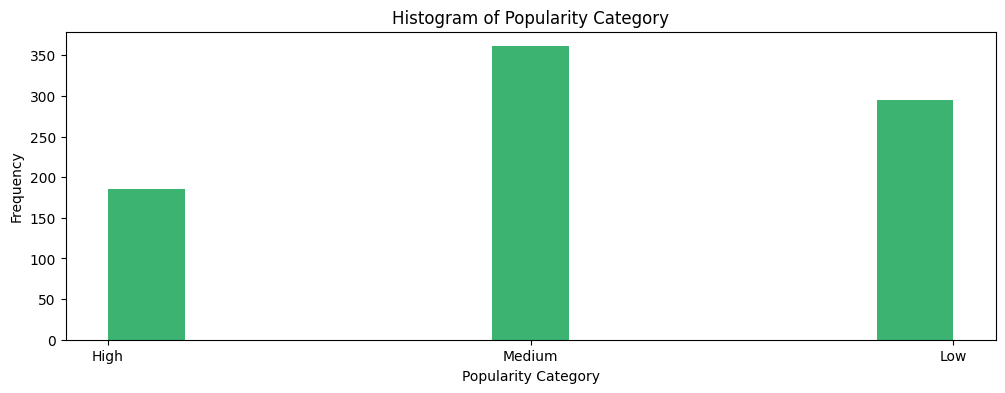

In [128]:
# Plot histogram of popularity categories
plt.figure(figsize=(12, 4))
plt.hist(station_usage['popularity_category'], bins='auto', color='mediumseagreen')
plt.title('Histogram of Popularity Category')
plt.xlabel('Popularity Category')
plt.ylabel('Frequency')
plt.show()

The categories are slightly unevenly distributed, but are uniform enough to function as a classification problem. The stations can again be plotted on a map to explore whether the clusters align with the above detected pattern of popular stations:

In [129]:
# Prepare data for plotting
plot_data = pd.DataFrame(station_usage)

# Prepare data for plotting and plot
TITLE = 'Clustered Stations'
LAT = plot_data['latitude']
LON = plot_data['longitude']
COLOR = plot_data['cluster']
TEXT = "Station Id: " + plot_data['station_id'].astype(str) + "<br>" + "Total Usage: " + plot_data['popularity_category'].astype(str)

single_map_plotter(TITLE, LAT, LON, COLOR, TEXT)

As expected, the *High*-usage stations have home on southern Manhattan, the *Medium* ones are a bit more spread out and the *Low* ones are mostly places on the outskirts.

When building the classifier, the data will be split into training, validation and test sets; to ensure that each category is represented in every set and that the test set tests for generalism, horizontal lines will be drawn through the stations map to illustrate the intended datasplitting. Here, everything north of the green line is training data, stations between the lines will be used for validation, and the remainder is the test data.

In [130]:
# Plot training, validation and testing split illustration
TITLE = 'Training, Validation and Testing Split'

single_map_plotter(TITLE, LAT, LON, COLOR, TEXT, SPLIT=True)

## 4.2 Incorporating Points of Interest

With the stations clustered into popularity, the dataset can now be extended with POIs in the stations' proximity. For this purpose, the `osmnx` module will be used to fetch geospatial information about POIs. 

For each station, the number of each instance of different amenities (like bus stops, train stations, schools, museums etc.) within a 100m radius will be added as features. For example, if a station has 3 bus stops within 100m, the station's 'bus stops' attribute will be 3. In addition, there will also be added atributes 'closest_distance_amenity_x' for each amenities x - within a maximum limit of 5000m away. For example, if a station's closest bus stop is 560m away, the 'closest_distance_amenity_bus_stop' attribute will be set to 560.

To get an idea of the different types of amenities in Manhattan, these can be fetched with oxmnx's `geometries_from_place`:

In [142]:
# Define a standard place name for the query
place = "Manhattan, New York"

# Use OSMnx to download the POIs for the specified place
try:
    pois = ox.features_from_place(place, tags={'amenity': True})
    
    # Get unique amenity values
    unique_amenities = pois['amenity'].unique().tolist()

    # Print the unique amenities
    print(f"Number of unique amenities: {len(unique_amenities)}")
    print(f"Unique amenities: {unique_amenities}")

except Exception as e:
    print(f"An error occurred: {e}")

Number of unique amenities: 127
Unique amenities: ['drinking_water', 'toilets', 'fast_food', 'school', 'social_facility', 'university', 'college', 'place_of_worship', 'hospital', 'clinic', 'research_institute', 'restaurant', 'theatre', 'post_office', 'arts_centre', 'cinema', 'bar', 'bench', 'courthouse', 'community_centre', 'doctors', 'fire_station', 'library', 'parking', 'police', 'prison', 'pub', 'cafe', 'bicycle_parking', 'ice_cream', 'atm', 'telephone', 'post_box', 'fountain', 'bank', 'pharmacy', 'ferry_terminal', 'motorcycle_parking', 'stripclub', 'marketplace', 'parking_entrance', 'waste_basket', 'taxi', 'bus_station', 'bbq', 'bicycle_rental', 'bureau_de_change', 'disused:restaurant', 'car_sharing', 'fuel', 'kindergarten', 'studio', 'dentist', 'car_rental', 'nightclub', 'shoe_repair', 'salon', 'urgent_care', 'spa', 'events_venue', 'money_transfer', 'public_bath', 'childcare', 'boat_rental', 'veterinary', 'vending_machine', 'language_school', 'animal_boarding', 'food_court', 'dojo

There are 127 unique amenities; since for each station the 1) number of instances of each amenity in a 100m radius and the 2) distance to each nearest amenity will be added as features, the dataset will be extended with 254 features. To aid in this feature creation, the created function `find_closest_amenity` below will be used:

In [140]:
def find_closest_amenity(lat, lon, amenity_type='restaurant'):
    # Define the location point
    location_point = (lat, lon)
    
    try:
        # Use OSMnx to download the POIs within 5,000 meters
        pois = ox.features_from_point(location_point, tags={'amenity': amenity_type}, dist=5000)
    except Exception as e:
        print(f"An error occurred while fetching POIs: {e}")
        return -1  # Return -1 immediately if there's an error fetching POIs

    # Initialize minimum distance
    min_distance = float('inf')

    # Iterate through the points of interest
    for _, row in pois.iterrows():
        geom = row.geometry
        if isinstance(geom, shapely.geometry.Point):
            poi_point = (geom.y, geom.x)
        elif isinstance(geom, shapely.geometry.Polygon):
            poi_point = geom.centroid.coords[0]
        elif isinstance(geom, shapely.geometry.LineString):
            poi_point = geom.coords[0]
        else:
            continue  # Skip other geometry types

        distance = haversine(location_point, poi_point, unit=Unit.METERS)
        if distance < min_distance:
            min_distance = distance

    # If no POI is found within 5000 meters, return -1
    return min_distance if min_distance != float('inf') else -1, poi_point

In [143]:
# Example usage of find_closest_amenity
lat = station_usage['latitude'][0]
lon = station_usage['longitude'][0]
distance, closest_toilet = find_closest_amenity(lat, lon, amenity_type='toilets')

print(f"Closest toilet is at location ({closest_toilet[1]:.2f}, {closest_toilet[0]:.2f}) with a distance of {distance:.2f} meters.")

Closest toilet is at location (40.71, -73.96) with a distance of 101.08 meters.


In [ ]:
# TODO: Extend dataset with POI features

**OBS: THIS IS THE END OF THE SECTION 4 PARTS INCLUDED IN THE FIRST DRAFT**

## 4.3 Reducing Dimensions

*INTRODUCTION; PCA*

In [ ]:
# TODO

## 4.4 Training a Classifier

*INTRODUCTION; (Random forest? SVM? RNN?)*

In [ ]:
# TODO

*EVALUATING THE CLASSIFIER; F1, ACCURACY, PRECISION...*

In [ ]:
# TODO

*CONCLUSION*

# 5 Conclusion

*CONCLUSION*

___
# Individual contributions

| Section              | August | Phillip | Jonas | Line |
|----------------------|--------|---------|-------|------|
| Introduction         |        |         |       |      |
| Data Analysis        | ✓      | ✓       |       |      |
| Prediction Challenge | ✓      | ✓       |       |      |
| Exploratory Challenge|        |         | ✓     |  ✓   |
| Conclusion           |        |         |       |      |

___
# Appendix

## A: Word counter

In [ ]:
# Used to count words in Markdown cells; run in separate notebook

import json

with open('project_format_suggestion.ipynb', encoding='utf-8') as json_file:
    data = json.load(json_file)

found = False
wordCount = 0
for each in data['cells']:
    if found: 
        break
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if '#' not in word and '___' not in word]
            if temp==['Individual', 'contributions']:
                found = True
                break
            wordCount = wordCount + len(temp)
            
print(f"Wordcount excluding Contributions and Appendix: {wordCount}")

## B: Map plotter

In [108]:
def single_map_plotter(TITLE, LAT, LON, COLOR, TEXT, ZOOM=10, SIZE=10, SPLIT=False):
    fig = make_subplots(rows=1, cols=1, subplot_titles=TITLE,
                        specs=[[{'type': 'mapbox'}]],
                        horizontal_spacing=0.01)

    # Add the plot
    fig.add_trace(go.Scattermapbox(
        lat=LAT,
        lon=LON,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=SIZE,
            color=COLOR,
            sizemode='area',
            sizemin=4
        ),
        text=TEXT,
        hoverinfo='text'
    ))

    # Update layout with mapbox details
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox=dict(
            center=go.layout.mapbox.Center(lat=40.73, lon=-73.99),
            zoom=ZOOM
        ),
        margin={"r":0,"t":0,"l":0,"b":0},
        showlegend=False,
        annotations=[dict(
        text=TITLE,
        x=0.5,
        y=0.95,
        xref='paper',
        yref='paper',
        showarrow=False,
        font=dict(
            size=20,
            family='Arial Black',
            color='darkblue'
        ),
        bgcolor='lightblue',
    )]
        
    )

    if SPLIT:
        # Define longitude range for horizontal lines
        lon_range = [-74.1, -73.9]

        # Add horizontal lines at latitudes 40.715 and 40.740
        fig.add_trace(go.Scattermapbox(
            mode="lines",
            lat=[40.780, 40.655],
            lon=lon_range,
            line=dict(width=2, color="red"),
            name="Line at latitude 40.715"
        ))
        fig.add_trace(go.Scattermapbox(
            mode="lines",
            lat=[40.800, 40.675],
            lon=lon_range,
            line=dict(width=2, color="green"),
            name="Line at latitude 40.740"
        ))

    # Show the figure
    fig.show()